## Basic Neural Net implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

# Basic neural net implementation with softmax output
class NeuralNet:
    def __init__(self,
                 input_dim = 2,
                 num_output = 2,
                 hidden_sizes = [],
                 nonlinearity = 'RELU',
                 learning_rate = 0.2,
                 loglevel = logging.WARNING):
        self.input_dim = input_dim
        self.num_output = num_output
        self.nonlinearity = nonlinearity.upper()
        # Xavier initialization of weights
        self.weights = [[] for i in range(len(hidden_sizes) + 1)]
        prev_layer_size = input_dim + 1
        for i, hidden_size in enumerate(hidden_sizes):
            self.weights[i] = np.random.randn(prev_layer_size,
                    hidden_size) / np.sqrt(prev_layer_size)
            prev_layer_size = hidden_size
        self.weights[-1] = np.random.randn(prev_layer_size,
                num_output)
        self.learning_rate = learning_rate
        self.log = logging.getLogger("")
        self.log.setLevel(loglevel)

    def __str__(self):
        return 'Weights: {}'.format(self.weights)

    def apply_nonlinearity_(self, a):
        if (self.nonlinearity == 'RELU'):
            return np.multiply(a, (a > 0))
        if (self.nonlinearity == 'SIGMOID'):
            return self.sigmoid(a)
        if (self.nonlinearity == 'TANH'):
            return np.tanh(a)

    def sigmoid(self, x):
        s = np.vectorize(lambda x: 1 / float(1 + np.exp(-1*x)))
        return s(x)

    def forward_propagate_(self, X):
        X = self.augment_X(X)
        a = X
        intermediates = []
        intermediates.append(a)
        for w in self.weights[0:-1]:
            a = np.dot(a, w)
            a = self.apply_nonlinearity_(a)
            intermediates.append(a)
        a = np.dot(a, self.weights[-1])
        return self.softmax(a), intermediates

    def softmax(self, a):
        d = a.shape[1]
        m = a.max()
        denom = np.tile(np.exp(a-m).sum(axis=1), (d, 1)).T
        return np.exp(a-m) / denom

    def predict(self, X):
        return np.argmax(self.forward_propagate_(X)[0], axis=1)

    # Backprop with batch gradient descent
    def backprop(self, X, Y):
        # Softmax backprop
        n = X.shape[0]
        probs, intermediates = self.forward_propagate_(X)
        # Gradient of cross-entropy loss w/ respect to intermediate output:
        # = p-1 if on target or p for off-target
        grad_a = probs # dim: (n x c)
        grad_a[range(Y.shape[0]), Y] -= 1
        # Gradient w/ respect to weight vector = grad_a * x
        # Dimension: (h x n) (n x c) => (h x c)
        grad_w = np.dot(intermediates[-1].T, grad_a) / float(n)
        # Gradient of loss w/ respect to intermediate outputs = grad_a * w
        grad_y = np.dot(grad_a, self.weights[-1].T)
        self.weights[-1] -= self.learning_rate * grad_w

        # Hidden layer backprop
        # Dimension: (n x c) (c x h) = (n x h)
        for (w, x) in reversed(zip(self.weights[:-1], intermediates[:-1])):
            # Gradient of intermediate ReLu output is just masked grad_y
            a = x.dot(w)
            grad_a = grad_y
            if self.nonlinearity == 'RELU':
                grad_a = np.multiply(grad_y, a > 0)
            if self.nonlinearity == 'SIGMOID':
                grad_a = np.multiply(grad_y, np.multiply(self.sigmoid(a), self.sigmoid(1-a)))
            if self.nonlinearity == 'TANH':
                grad_a = np.multiply(grad_y,
                        1 - np.multiply(np.tanh(a), np.tanh(a)))
            # Gradient of w = grad_x
            # Dim: (n x h_in).T (n x h_out) = (h_in x h_out)
            grad_w = (x.T).dot(grad_a) / float(n)
            # Gradient of previous output
            # Dim: (n x h_out) (h_out x h_in) = (n x h_in)
            grad_y = grad_a.dot(w.T)
            # Update weights
            w -= self.learning_rate * grad_w

    def calc_loss(self, X, Y):
        probs, _ = self.forward_propagate_(X)
        n = X.shape[0]
        return -1. * np.log(probs[range(Y.shape[0]), Y]).sum() / n

    def fit(self, X, Y, max_iter=5000, plot_loss=False, print_loss=False):
        loss = np.zeros(max_iter / 100 + 1)
        loss[0] = float('inf')
        iter = 0
        for i in range(max_iter):
            if plot_loss or print_loss:
                if i % 100 == 0:
                    curr_loss = self.calc_loss(X, Y)
                    loss[i/100 + 1] = curr_loss
            self.backprop(X, Y)
        if plot_loss:
            plt.plot(np.arange(0, max_iter, 100), loss[1:])
        if print_loss:
            print('Loss: {}'.format(loss))

    # Add a column of 1's to X for bias term
    def augment_X(self, X):
        n = X.shape[0]
        return np.c_[np.ones(n), X]

    # Copied from dennybritz nn-from-scratch
    def plot_decision_boundary(self, X, Y):
        width_bounds = (X[:,0].min() - .5, X[:,0].max() + .5)
        height_bounds = (X[:,1].min() - .5, X[:,1].max() + .5)
        h = 0.01
        x1, x2 = np.meshgrid(np.arange(width_bounds[0], width_bounds[1], h),
                np.arange(height_bounds[0], height_bounds[1], h))
        Z = self.predict(np.c_[x1.ravel(), x2.ravel()])
        Z = Z.reshape(x1.shape)
        plt.contourf(x1, x2, Z)
        plt.scatter(X[:,0], X[:,1], c=Y)


Test with make_moons dataset

In [3]:
%matplotlib inline
import sklearn.datasets
X, y = sklearn.datasets.make_moons(200, noise=0.20)


## Tanh hidden layer

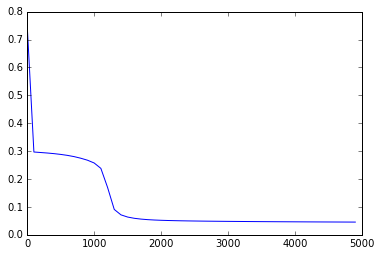

In [9]:
nn = NeuralNet(input_dim=2, num_output=2, learning_rate=0.5, hidden_sizes=[3], nonlinearity='TANH')
nn.fit(X,y,plot_loss=True)

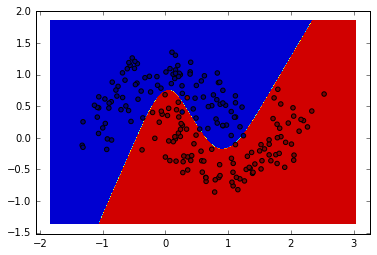

In [10]:
nn.plot_decision_boundary(X,y)

## Sigmoid hidden layer

Loss looks a bit wonky here, increases at ~iter 2000?

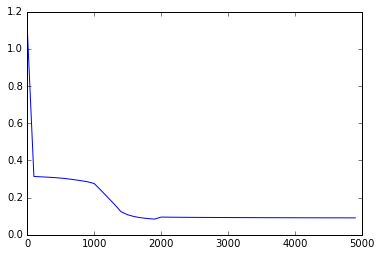

In [6]:
nn = NeuralNet(input_dim=2, num_output=2, learning_rate=2.5, hidden_sizes=[3], nonlinearity='SIGMOID')
nn.fit(X,y,plot_loss=True)

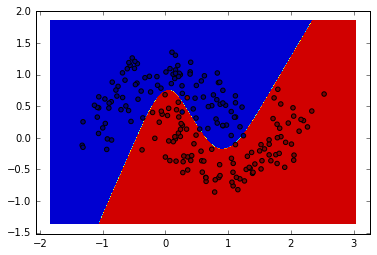

In [11]:
nn.plot_decision_boundary(X,y)

## ReLu hidden layer

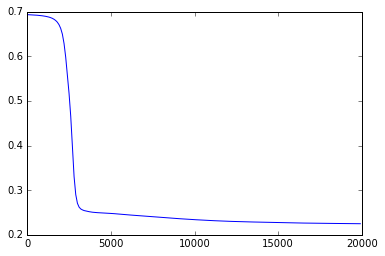

In [16]:
nn = NeuralNet(input_dim=2, num_output=2, learning_rate=0.01, hidden_sizes=[4, 3, 3], nonlinearity='RELU')
nn.fit(X,y,max_iter=20000, plot_loss=True)

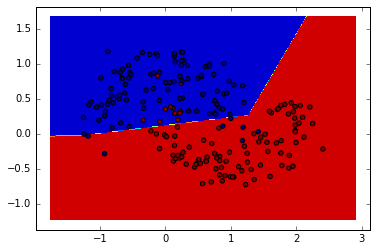

In [17]:
nn.plot_decision_boundary(X, y)

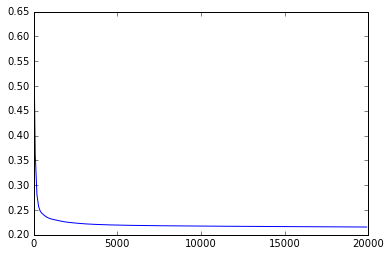

In [18]:
wide_nn = NeuralNet(input_dim=2, num_output=2, learning_rate=0.01, hidden_sizes=[10], nonlinearity='RELU')
wide_nn.fit(X,y,max_iter=20000, plot_loss=True)

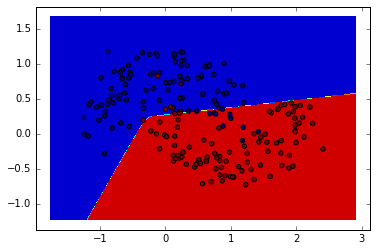

In [19]:
wide_nn.plot_decision_boundary(X, y)